In [1]:
import numpy as np
import pymc3 as pm
from scipy import stats
from custom_metrics import *
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython.display import Image, display
from scipy.special import gammaln ,digamma
from tqdm import tqdm
import sys

<h1><center>A Probabilistic Model for "Yes" or  "No" Queries:  
Crowdsourcing Multi-Class Classification Tasks </center></h1> 
<h2><center>Use Case</center></h2>

**1. Select the folder data:**

In [2]:
selected_folder = './catalina/'

**2. Load the data:**

In [3]:
# users + number of YN question selected for them as.
info_experts = pd.read_csv(selected_folder+'users.csv') 

In [4]:
# responses for the YN queries
votes = pd.read_csv(selected_folder+'votes_yn.csv') 

# objects to be classified
objects = pd.read_csv(selected_folder+'objects.csv') 

# users + number of YN question selected for them as.
info_experts = pd.read_csv(selected_folder+'users.csv') 
info_experts = info_experts.set_index('id')

In [5]:
print("Training set size {}".format(objects._training.sum()))
print("Testing set size {}".format(objects._validation.sum()))
print("Number of objecs required ABCD and YN votes {}".format(objects._abc.sum()))

Training set size 41
Testing set size 317
Number of objecs required ABCD and YN votes 80


In [6]:
# Selecting the users who complete at least 70% of their contest's questions:
number_of_given_answers = dict(votes.expert_id.value_counts())
info_experts['percentage_done'] = 0
for key in number_of_given_answers:
    _total_question_created_for_this_expert = float(info_experts.loc[key].initial_yn_questions)
    info_experts.loc[key].percentage_done = float(number_of_given_answers[key])/_total_question_created_for_this_expert
info_experts = info_experts.reset_index()
info_experts = info_experts[info_experts.percentage_done >= .7]

**3 .Selecting data for running the model:**

In [7]:
# Selected annotators
experts = info_experts.id.values

# Filtering the votes
votes = votes[votes.expert_id.isin(experts)]

o_columns = objects[['catalina_id','Var_Type','_training','_validation']]

In [8]:
experts, experts.shape[0]

(array([19, 10,  9, 12,  6,  4, 13, 14]), 8)

In [9]:
o_columns.Var_Type.unique()

array(['CEP', 'EB', 'LPV', 'RRLYR'], dtype=object)

In [10]:
# Number of possible classes
K = o_columns.Var_Type.unique().shape[0]

# Number of annotators
J = experts.shape[0]

# Fit the annotators id with a sequential number
inv_experts_id = dict(zip(experts, range(J)))

# Fit the classes names with a sequential number
classes_dict = dict(zip(range(K),list(o_columns.Var_Type.unique())))
inv_classes_dict = {classes_dict[a]:a for a in classes_dict}

# I. Data Training Credibility Stage

In [11]:
# Getting the true classes' dirstribution
Ns_dict = dict(o_columns[o_columns._training].Var_Type.value_counts())
Ns = np.array([Ns_dict[classes_dict[i]] for i in classes_dict])
N = np.sum(Ns)

# Getting the true proportion classes' dirstribution
p = Ns / N

# LABELS GROUND TRUTH - TRAINING SET
zt = np.array([inv_classes_dict[_] for _ in o_columns[o_columns._training].Var_Type])

In [12]:
# Generatting the r matrix of votes from the source data
def matrix_votes(J, N, K, o_columns, votes):
    r_ = np.zeros((J, N, K, 2))
    for i in range(o_columns.shape[0]):
        instance = o_columns.iloc[i]
        _votes = votes[votes.object_id == instance.catalina_id]
        for v in range(_votes.shape[0]):
            vote = _votes.iloc[v]
            r_[inv_experts_id[vote.expert_id], i,  inv_classes_dict[vote.question], 1-vote.value] = 1
    return r_

In [13]:
# Getting the votes for the users KNOWN LABELS - TRAINING PART
r_true = matrix_votes(J, N, K, o_columns[o_columns._training], votes)  

# II. Data Testing Labeling Stage

In [14]:
# Getting the true classes' dirstribution
Ns_test_dict = dict(o_columns[~o_columns._training].Var_Type.value_counts())
Ns_test = np.array([Ns_test_dict[classes_dict[i]] for i in classes_dict])
N_test = Ns_test.sum()

# Getting the true proportion classes' dirstribution
p_test = Ns_test/N_test

# LABELS GROUND TRUTH - TESTING SET
zt_test = np.array([inv_classes_dict[_] for _ in o_columns[~o_columns._training].Var_Type])

In [15]:
# Getting the votes for the users UKNOWN LABELS - TESTING PART
r_test = matrix_votes(J, N_test, K, o_columns[~o_columns._training], votes)  

# III. PYMC IMPLEMENTATION

### III. a) PYMC implementation - Credibility

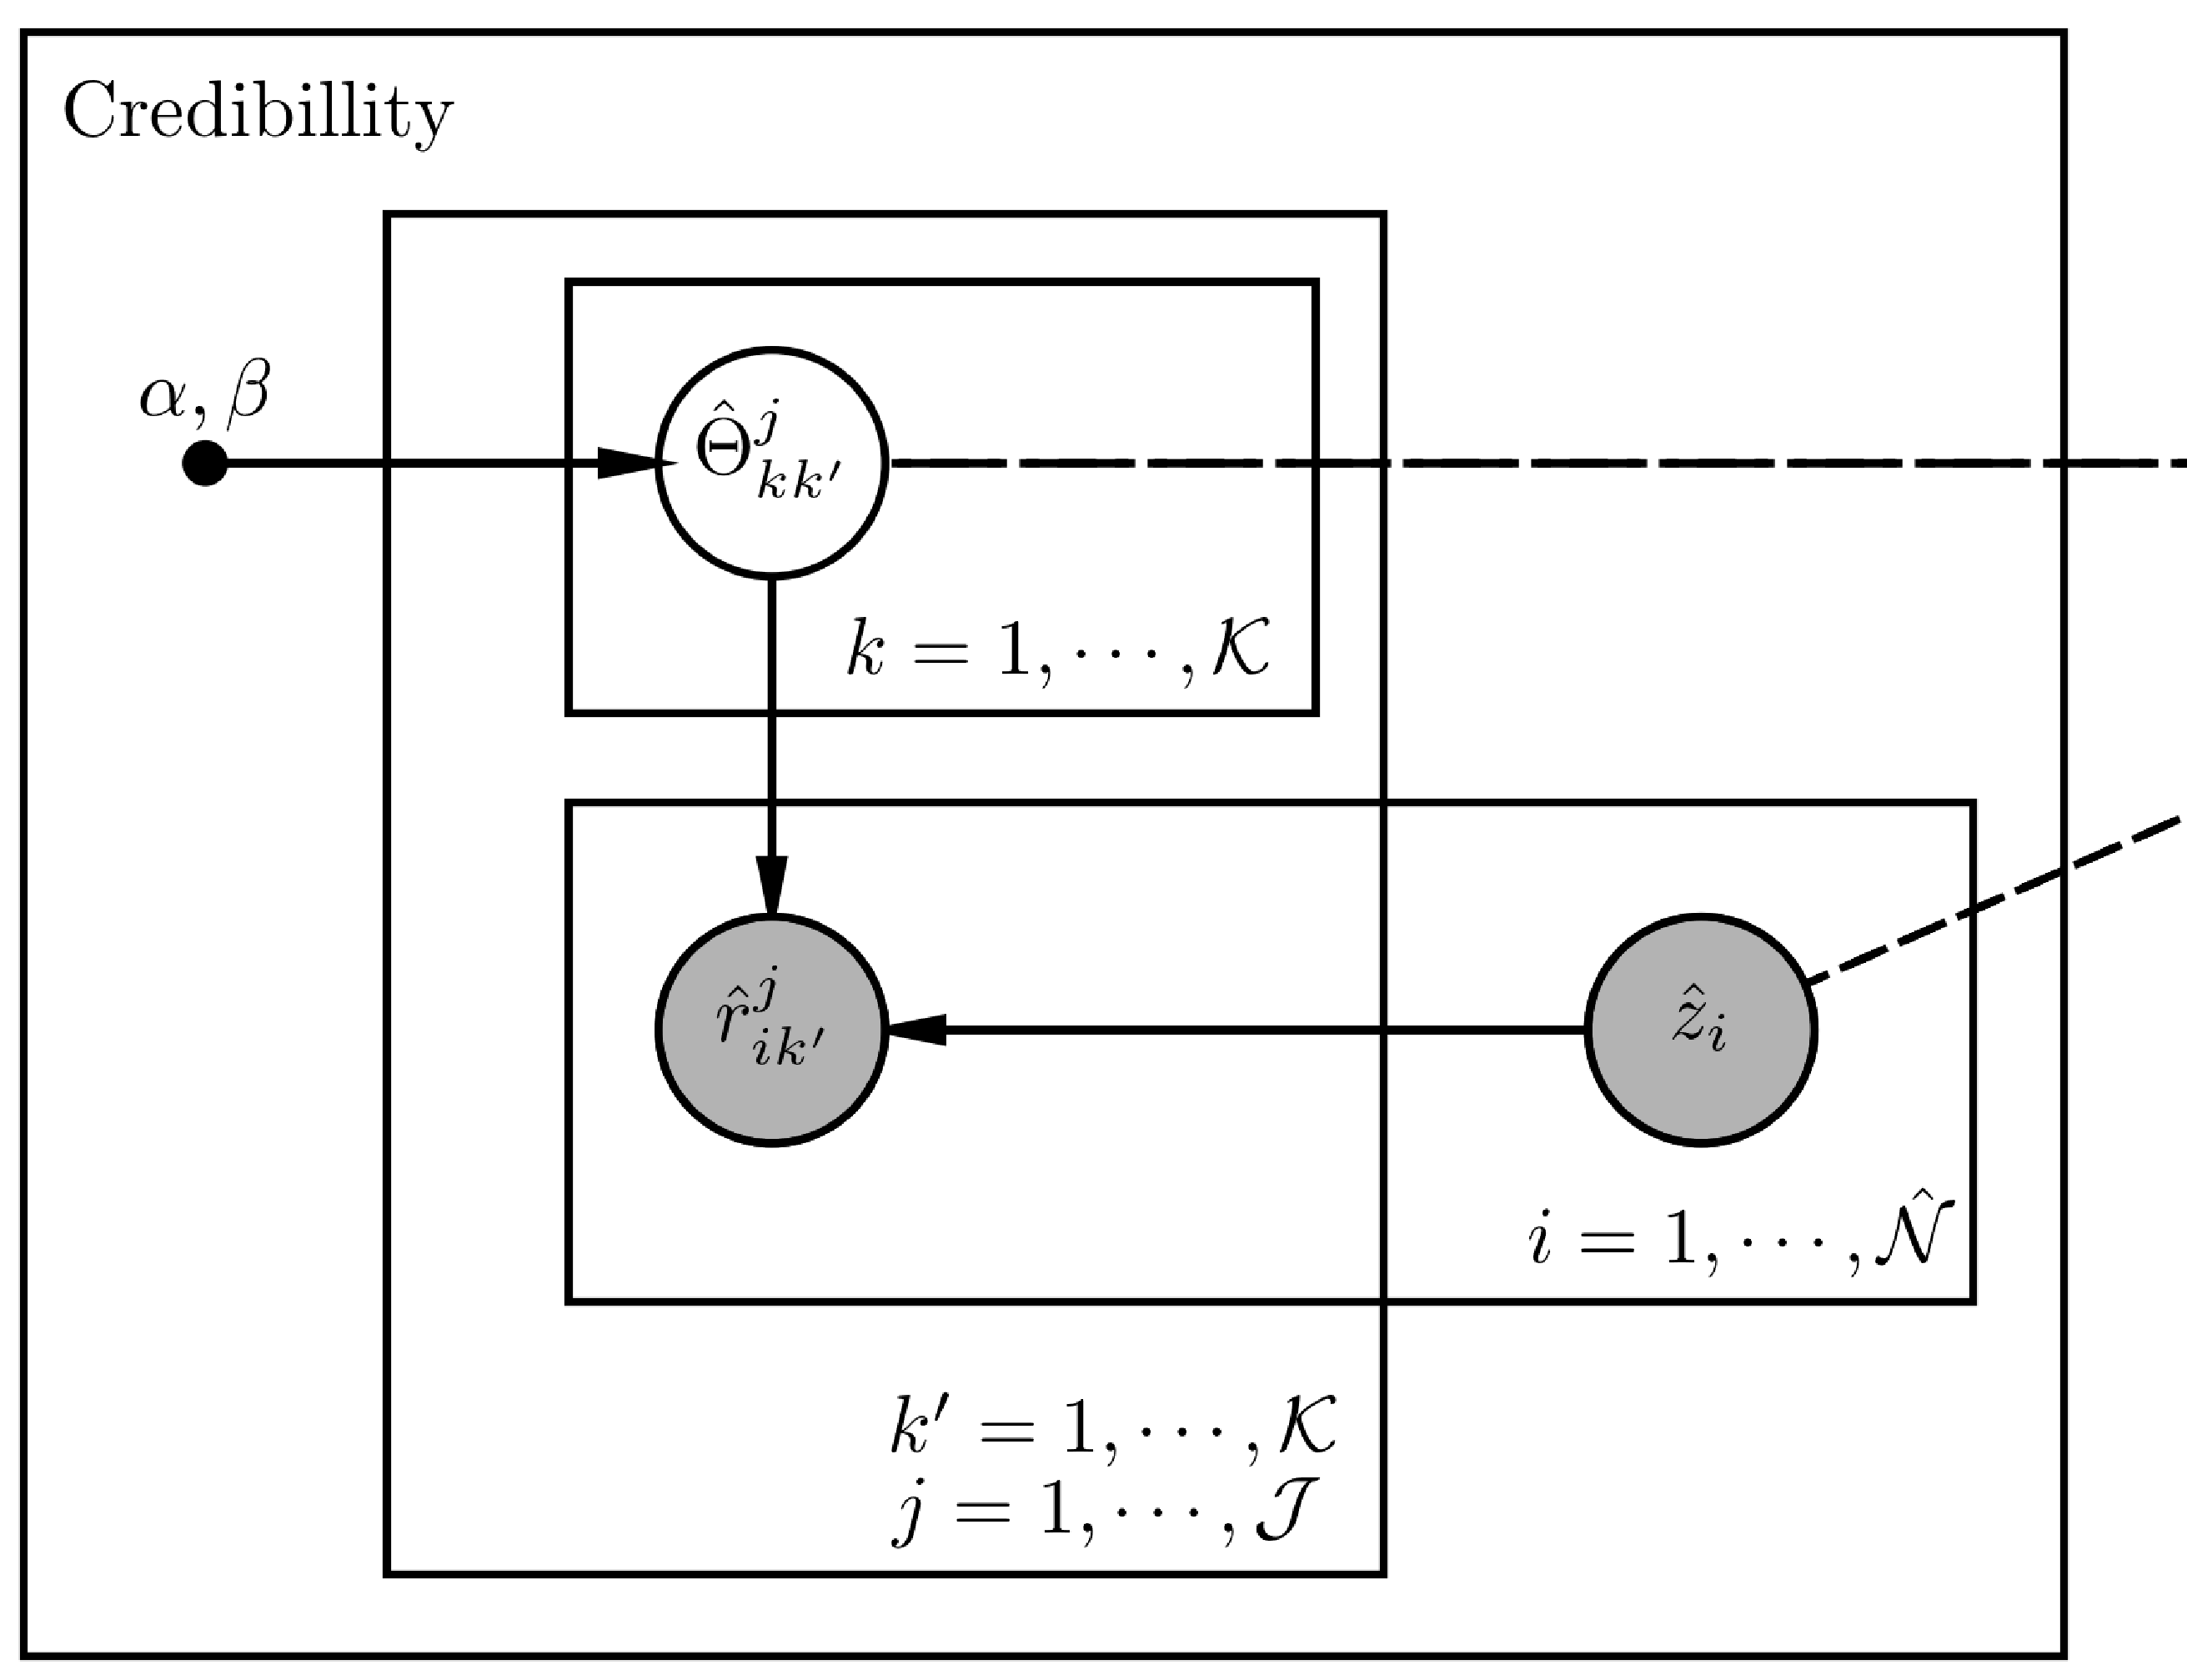

In [16]:
Image(filename="images/credibility.png", width=400)

In [17]:
ALPHA = .5
BETA = .5

with pm.Model() as model: 
    
    theta = pm.Beta('theta', alpha=ALPHA, beta=BETA, shape=(J, K, K))
    z = pm.Categorical('z', p=p , observed=zt, shape=N)

    # EQUATION (4.3)
    def likelihood_Pt_rz(value, theta=theta, zt=z):
        l=np.log(theta[:, zt,:]**value[:,:,:,0] * (1-theta[:,zt,:])**(value[:,:,:,1]))
        return l.sum()
    
    r = pm.DensityDist('r', likelihood_Pt_rz, observed=(r_true))
    
with model:
    step = pm.Metropolis([theta])
    trace = pm.sample(20000, step)

100%|██████████| 20000/20000 [00:06<00:00, 3264.48it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9d145849b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f9cde483080>]], dtype=object)

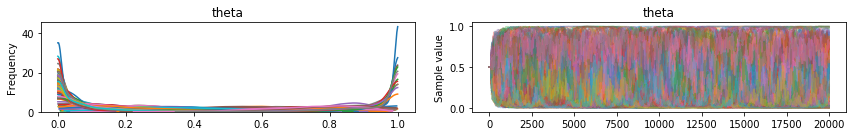

In [18]:
pm.plots.traceplot(trace)

### III. b) PYMC implementation - Labeling

In [ ]:
# Using the parameters estimation from the Training Stage
# as prior parameter for the Labeling Stage

# This is one of the most important parts of the proposed model
theta_val = trace[theta][-5000::20].mean(axis=0)
theta_sd = trace[theta][-5000::20].std(axis=0)

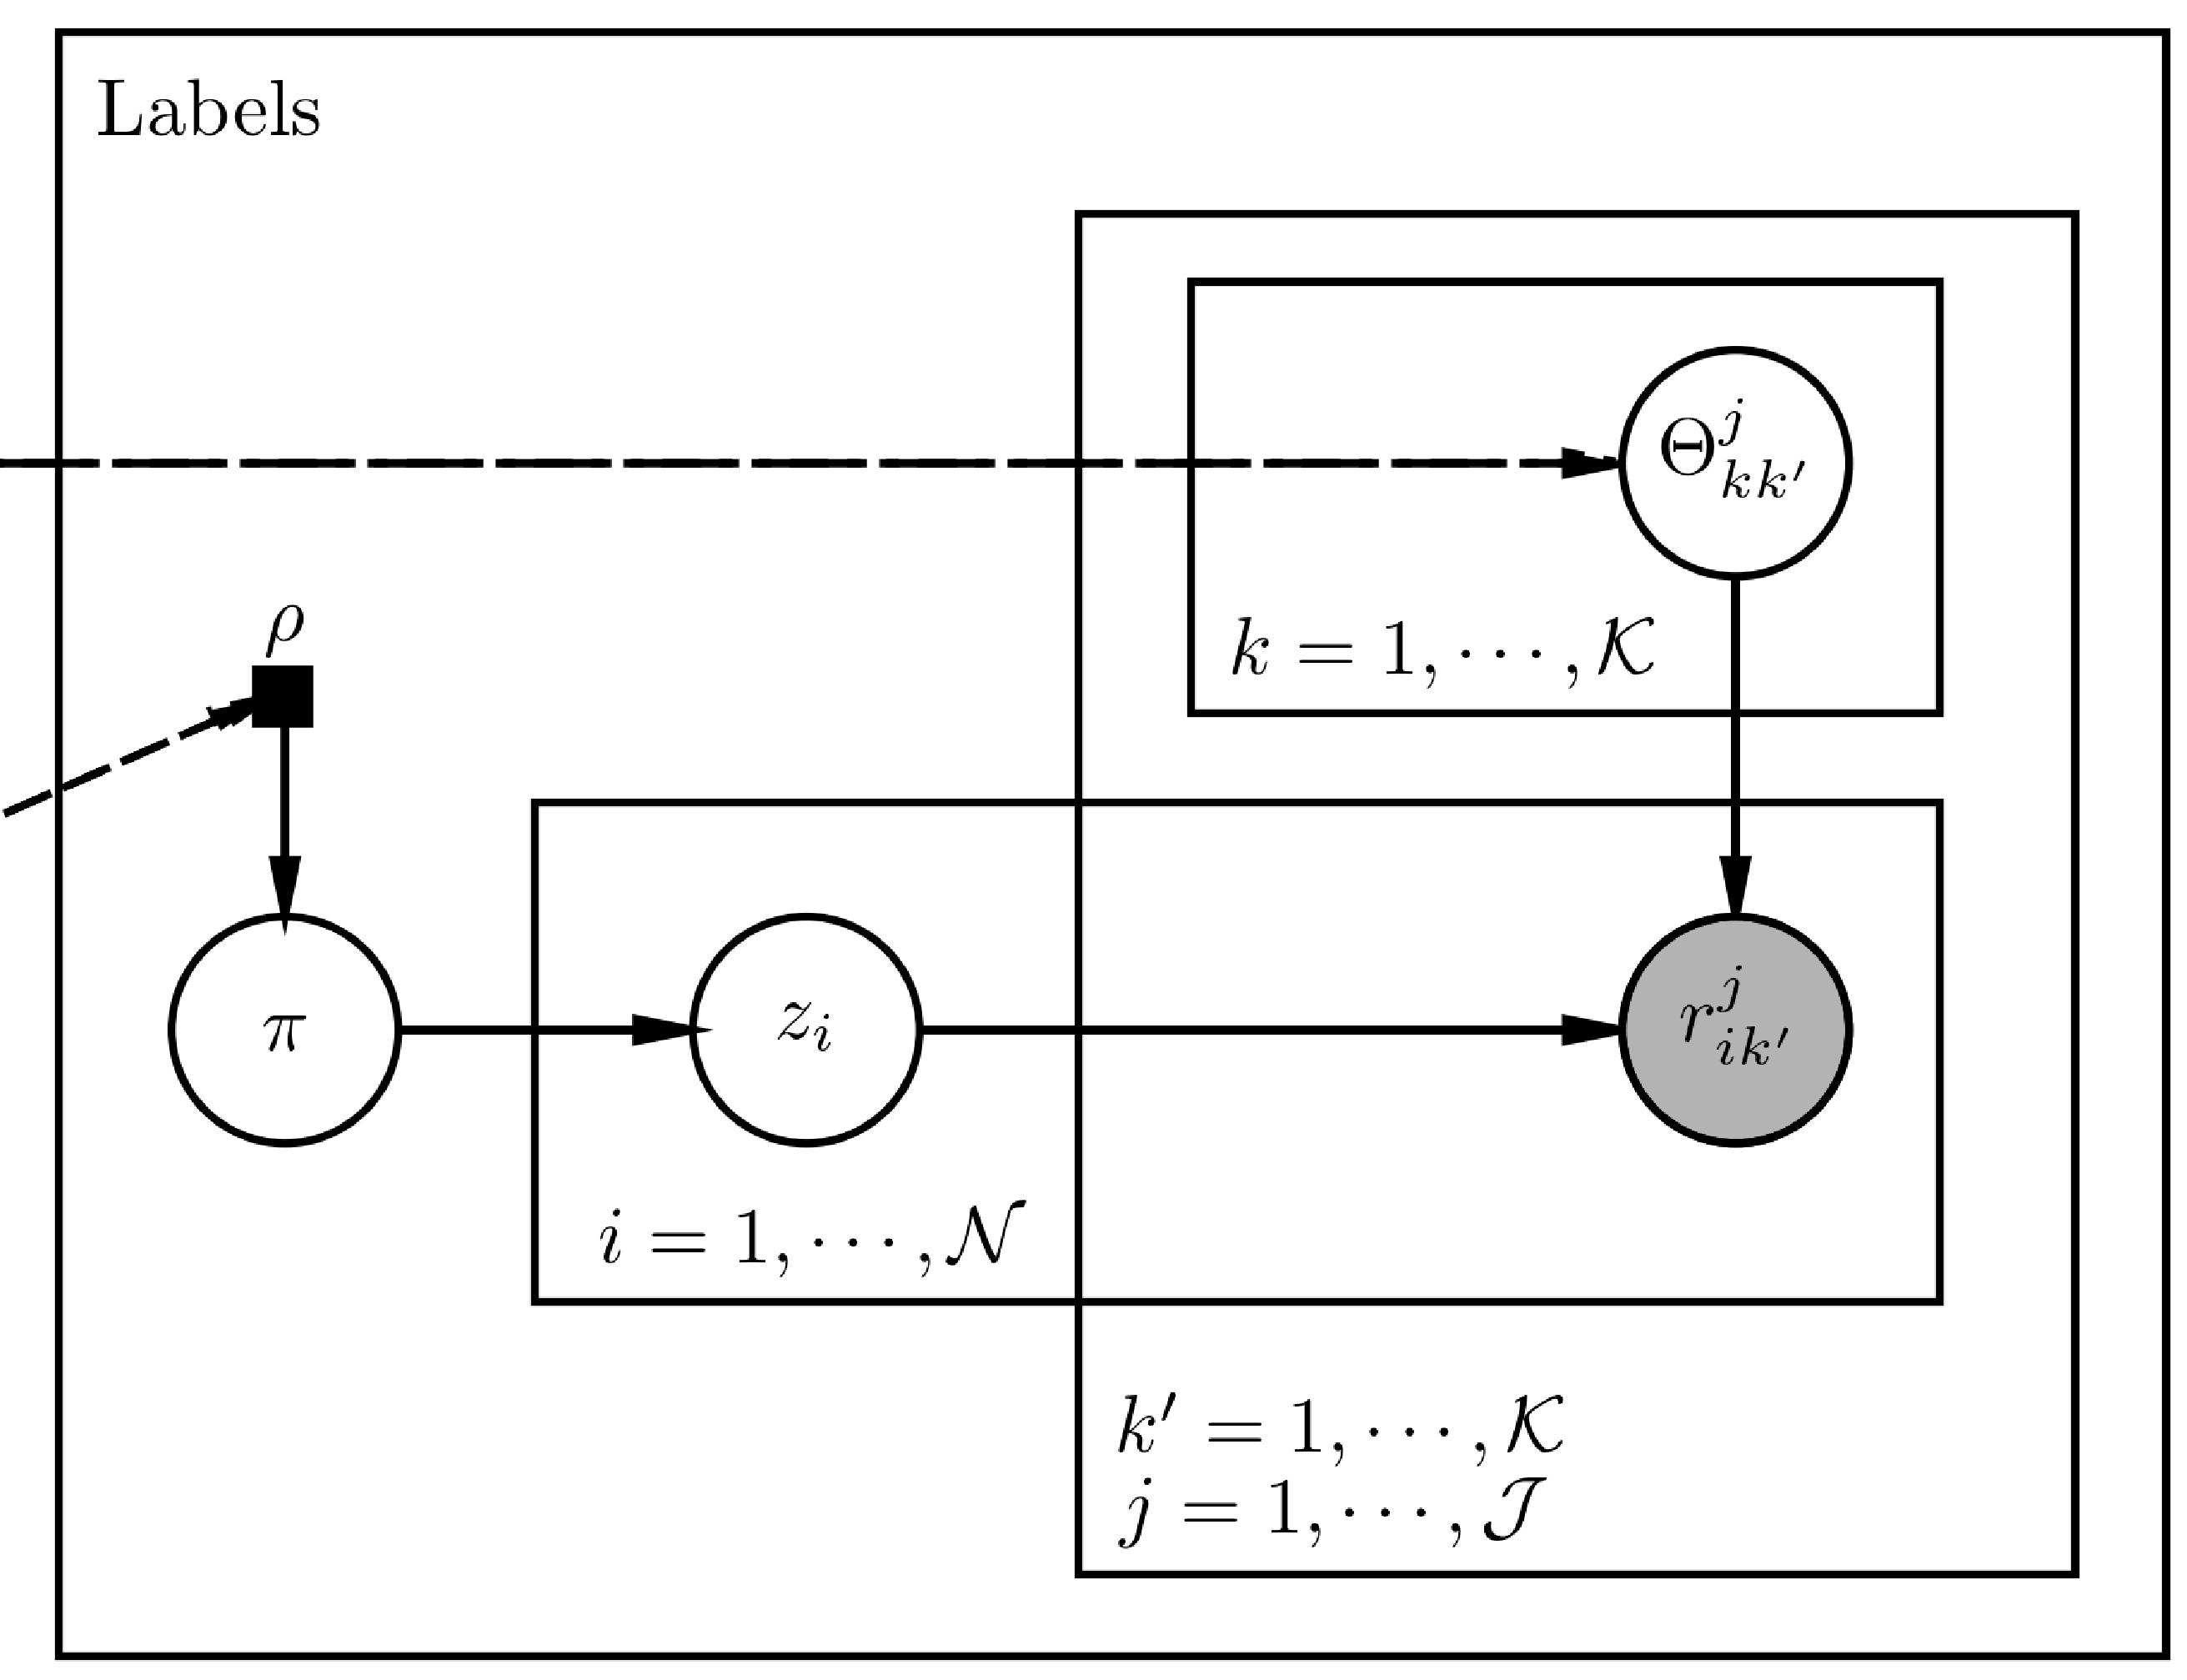

In [20]:
Image(filename="images/labeling.png", width=400)

**Data review**

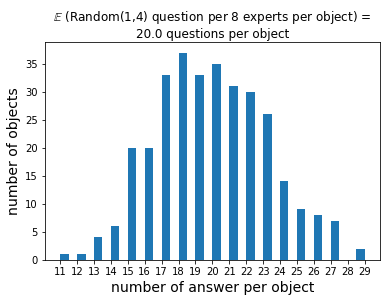

In [21]:
# E{ Random(1,4) } = Number of questions per object per expert = 2.5
# 8 experts,  8 * E{ Random(1,4) } = 20
plt.hist(r_test.sum(0).sum(1).sum(1), bins=18*2)
plt.xlabel('number of answer per object', fontsize=14)
plt.ylabel('number of objects', fontsize=14)
plt.xticks(np.arange(11,30),np.arange(11,30))
plt.title('$\mathbb{E}$ (Random(1,4) question per 8 experts per object) = '+\
          '\n{} questions per object'.format(J * 2.5))

In [22]:
with pm.Model() as model2: 
    
    pi = pm.Dirichlet('pi', p)
    z_unknown = pm.Categorical('z_unknown', p=pi, shape=N_test)
    new_theta = pm.Beta('new_theta', mu=theta_val, sd=theta_sd, shape=(J, K, K))        

    # EQUATION (3.2)
    def likelihood_Pzt_r(value, zt=z_unknown, theta=new_theta, pzs=pi):
        l = np.log(theta[:, zt,:]**value[:,:,:,0] * (1-theta[:,zt,:])**(value[:,:,:,1]))
        return l.sum()
    
    r = pm.DensityDist('r', likelihood_Pzt_r, observed=(r_test))

with model2:   
    step1 = pm.Metropolis([new_theta, pi])
    step2 = pm.CategoricalGibbsMetropolis([z_unknown])
    
    # for full convergence njobs should be about 10.
    # for sppiding up the demo we use njobs=1
    trace2 = pm.sample(3000, step=[step1, step2], njobs=1)

100%|██████████| 3000/3000 [10:24<00:00,  5.33it/s]


In [23]:
print("Credibility part TRUE proportion distribution {}".format(p))
print("Labeling part TRUE proportion distribution {}".format(p_test))
print("Labeling part LEARNED proportion distribution {}".format(trace2[pi][-100::10].mean(axis=0)))

Credibility part TRUE proportion distribution [ 0.34146341  0.2195122   0.17073171  0.26829268]
Labeling part TRUE proportion distribution [ 0.33123028  0.22397476  0.16719243  0.27760252]
Labeling part LEARNED proportion distribution [ 0.26361508  0.25649239  0.19401874  0.28587379]


In [24]:
# MAP
v, f = stats.mode(trace2[z_unknown][-500::10])
result = v[0]

[[ 0.781  0.162  0.038  0.019]
 [ 0.     1.     0.     0.   ]
 [ 0.     0.     1.     0.   ]
 [ 0.     0.     0.     1.   ]]


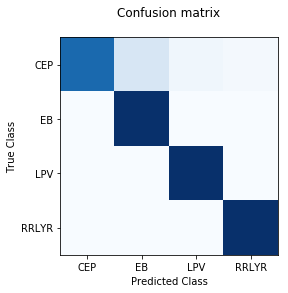

Acurracy score 0.927444794953


Metrics / Classes,CEP,EB,LPV,RRLYR
Precision score,1.0,0.807,0.93,0.978
Recall score,0.781,1.0,1.0,1.0
F score,0.877,0.893,0.964,0.989


In [25]:
draw_metrics(zt_test, result, [classes_dict[i] for i in range(K)])

# IV. BBVI IMPLEMENTATION

Implementation based on

<h4><center>
A Guide to Black Box Variational Inference for Gamma Distributions
<br>
Allison J.B. Chaney
<br>
October 27, 2015
<br>
http://ajbc.io/resources/bbvi_for_gammas.pdf
</center></h4>




In [26]:
np.random.seed(11)

### IV. a) BBVI implementation - Credibility

In [27]:
## helper functions
# soft-plus
def SP(x):
     return np.log(1.+np.exp(x))

#derivative of soft-plus
def dSP(x):
    return np.exp(x)/(1.+np.exp(x))

#inverse of soft-plus
def iSP(x):
    return np.log(np.exp(x)-1.)

# log probability of a beta
def Beta(t, a, b):
    p = (a-1)*np.log(t) + (b-1)*np.log(1-t) + gammaln(a+b) - gammaln(a) - gammaln(b)
    return p

# derivative of above logbeta with respect to sparsity a
def dBeta_alpha(t, a, b):
    p = np.log(t) + digamma(a+b) - digamma(a)
    return p

# derivative of above logbeta with respect to sparsity b
def dBeta_beta(t, a, b):
    p = np.log(1-t) + digamma(a+b) - digamma(b)
    return p

# covariance where each column is draws for a variable
# (returns a row of covariances)
def cov(a,b):
    v = (a-sum(a)/a.shape[0])*(b-sum(b)/b.shape[0])
    return sum(v)/v.shape[0]

# variance with same structure as covariance above
def var(a):
    return cov(a,a)

## setup for inference
# the number of samples to draw for each parameter
S = 1024

In [28]:
# used for RMSprop
MS_alpha = np.zeros((J,K,K))
MS_beta = np.zeros((J,K,K))

In [29]:
# initialize; randomness not needed here, but may be for
# other models
lambda_alpha=0.5*np.ones((J,K,K))
lambda_beta=0.5*np.ones((J,K,K))

alpha_0 = .5
beta_0 = .5

# log probability of a Bernoulli distribution with param theta
# probability of observations given samples
def Binomial(r, zt, sample_thetas):
    return np.log(sample_thetas[:, :, zt]**r[:, :,0] * (1-sample_thetas[:, :, zt])**r[:, :,1])

In [30]:
iteration=0

In [31]:
# run BBVI for a fixed number of iterations
for iteration in  tqdm(range(iteration, 1000)):
    sample_thetas = np.random.beta(
        SP(lambda_alpha), SP(lambda_beta), (S, J, K, K))

    # truncate samples (don’t sample zero)
    sample_thetas[sample_thetas < 1e-300] = 1e-300

    # probability of samples given prior
    P = Beta(sample_thetas, alpha_0, beta_0)

    # probability of samples given variational parameters
    Q = Beta(sample_thetas, SP(lambda_alpha), SP(lambda_beta))

    # gradients of variational parameters alpha, beta given samples (Chain Rule)
    g_alpha = dSP(lambda_alpha) * \
        dBeta_alpha(sample_thetas, SP(lambda_alpha), SP(lambda_beta))

    g_beta = dSP(lambda_beta)*dBeta_beta(sample_thetas, SP(lambda_alpha), SP(lambda_beta))

    # probability of observations given samples
    for i in range(N):
        P[:,:,zt[i]] += Binomial(r_true[:,i], zt[i], sample_thetas)
        
    # control variates to decrease variance of gradient;
    # one for each variational parameter
    cv_alpha = cov(g_alpha*(P-Q), g_alpha)/var(g_alpha)
    cv_beta = cov(g_beta*(P-Q), g_beta)/var(g_beta)

    # RMSprop: keep running average of gradient magnitudes
    # (the gradient will be divided by sqrt of this later)
    if MS_beta.all() == 0:
        MS_beta = (g_beta**2).sum(0)
        MS_alpha = (g_alpha**2).sum(0)
    else:
        MS_beta = 0.9*MS_beta+0.1*(g_beta**2).sum(0)
        MS_alpha = 0.9*MS_alpha+0.1*(g_alpha**2).sum(0)

    # Robbins-Monro sequence for step size
    rho = (iteration+1024)**-0.7

    # update each variational parameter with smaple average
    lambda_beta += rho*(1./S)*(g_beta/np.sqrt(MS_beta)*(P-Q-cv_beta)).sum(0)
    lambda_alpha += rho*(1./S)*(g_alpha/np.sqrt(MS_alpha)*(P-Q-cv_alpha)).sum(0)

    # truncate variational parameters
    lambda_alpha[lambda_alpha < iSP(0.005)] = iSP(0.005)
    lambda_beta[lambda_beta < iSP(1e-5)] = iSP(1e-5)
    lambda_alpha[lambda_alpha > iSP(np.log(sys.float_info.max))] = iSP(
        np.log(sys.float_info.max))
    lambda_beta[lambda_beta > iSP(np.log(sys.float_info.max))] = iSP(
        np.log(sys.float_info.max))


100%|██████████| 1000/1000 [02:39<00:00,  5.28it/s]


### IV. b) BBVI implementation - Labeling

In [32]:
estimate_SP = SP(lambda_alpha) / (SP(lambda_alpha) + SP(lambda_beta))

In [ ]:
# log probability of a dirichlet
def Dirichlet(x, vector):
    p = ((vector-1)*np.log(x)).sum(-1) - gammaln(x).sum(-1) + gammaln(vector.sum(-1))
    return p

# log probability of a categorical
def Categorical(x, vector):
    p = x*np.log(vector)
    return p.sum(-1)

def dCategorical_ci(x, c):
    p = x/c
    return p

def dDirichlet_di(x, d):
    p = np.log(x) - digamma(d) - digamma(d.sum())
    return p

## helper functions
def DSP(x):
    _sp = np.log(1.+np.exp(x))
    
    # x is a matrix
    # we need to normalize per row = dimension -1
    __sp = np.repeat(np.matrix((_sp).sum(-1)),4,0).T
    return np.array(_sp / __sp)

#derivative of DSP
def dDSP(x):
    _sp = np.log(1.+np.exp(x))
    __sp = np.array(np.repeat(np.matrix((_sp).sum(-1)),4,0).T)
    return np.exp(x)/(1.+np.exp(x))* ( 1/__sp - _sp*__sp**-2)

In [33]:
# Using the parameters estimation from the Training Stage
# as prior parameter for the Labeling Stage

# This is one of the most important parts of the proposed model
lambda_alpha_posterior=SP(lambda_alpha)
lambda_beta_posterior=SP(lambda_beta)

alpha_0 = SP(lambda_alpha)
beta_0 = SP(lambda_beta)

lambda_di_posterior=np.ones(K)/K
di_0 = p

lambda_ci_posterior=np.ones((N_test, K))/K
ci_0 = np.ones((N_test, K))*p

# used for RMSprop
MS_alpha = np.zeros((J,K,K))
MS_beta = np.zeros((J,K,K))
MS_di = np.zeros(K)
MS_ci = np.zeros((N_test, K))

In [34]:
iteration2 = 0

In [35]:
S = 1024*3

In [36]:
np.random.seed(111)

In [37]:
# run BBVI for a fixed number of iterations
for iteration2 in  tqdm(range(iteration2, 4)):

    sample_thetas = np.random.beta(
        SP(lambda_alpha_posterior), SP(lambda_beta_posterior), (S, J, K, K))

    sample_c = np.array([np.random.multinomial(1, DSP(lambda_ci_posterior)[_zi], S) 
                         for _zi in range(N_test)]).transpose((1,0,2))
    
    sample_d = np.random.dirichlet(DSP(lambda_di_posterior)[0], S)#(DSP(lambda_di_posterior)[0], S)
    
    # truncate samples (don’t sample zero)
    sample_thetas[sample_thetas < 1e-300] = 1e-300
    sample_d[sample_d < 1e-300] = 1e-300
    sample_c[sample_c < 1e-300] = 1e-300
    sample_d[sample_d < 1e-300] = 1e-300

    # EQUATION (Appendix 4.20)
    # probability of samples given prior
    p_thetas = Beta(sample_thetas, alpha_0, beta_0)

    # EQUATION (Appendix 4.22)
    p_pi = Dirichlet(sample_d, di_0)
    p_pi[np.abs(p_pi)==0] = -1e20  
    p_pi = np.reshape(np.repeat(p_pi, K), (S, K))
    
    # EQUATION (Appendix 4.21)
    _s_d = np.array([sample_d for i in range(N_test)]).transpose([1,0,2])
    p_zt = Categorical(sample_c, _s_d)
    p_zt[np.abs(p_zt)==0] = -1e20  
    
    # EQUATION (Appendix 4.24)
    # probability of samples given variational parameters
    q_theta = Beta(sample_thetas, SP(lambda_alpha_posterior), SP(lambda_beta_posterior))
    
    # EQUATION (Appendix 4.25)
    q_zt = Categorical(sample_c, DSP(lambda_ci_posterior))
    
    # EQUATION (Appendix 4.26)
    q_pi = Dirichlet(sample_d, DSP(lambda_di_posterior))
    
    # gradients of variational parameters alpha, beta, c=pi, d (Chain Rule)
    # EQUATION (Appendix 4.27)
    g_alpha = dSP(lambda_alpha_posterior) * dBeta_alpha(sample_thetas, 
                                    SP(lambda_alpha_posterior), SP(lambda_beta_posterior))
    
    # EQUATION (Appendix 4.28)
    g_beta = dSP(lambda_beta_posterior)*dBeta_beta(sample_thetas, 
                                    SP(lambda_alpha_posterior), SP(lambda_beta_posterior))

    # EQUATION (Appendix 4.29)
    g_c = dDSP(lambda_ci_posterior)*dCategorical_ci(sample_c, DSP(lambda_ci_posterior))

    # EQUATION (Appendix 4.30)
    g_d = dDSP(lambda_di_posterior)*dDirichlet_di(sample_d, DSP(lambda_di_posterior))
    

    
    # EQUATION (Appendix 4.19)
    # EQUATION (Appendix 4.23)
    # probability of observations given samples
    for _s in range(S):
        _zs = sample_c[_s].argmax(1)
        for i in range(N_test):
            _bin = Binomial(r_test[:,i], _zs[i], sample_thetas[_s])
            _cat = Categorical(sample_c[_s,i], sample_d[_s])
            
            p_thetas[_s,:,_zs[i]] += _bin + _cat
            p_zt[_s,i] += _bin.sum()
            p_pi[_s,_zs[i]] += _bin.sum()

    # control variates to decrease variance of gradient;
    # one for each variational parameter
    cv_alpha = cov(g_alpha*(p_thetas-q_theta), g_alpha)/var(g_alpha)
    cv_beta = cov(g_beta*(p_thetas-q_theta), g_beta)/var(g_beta)
    
    _p_zt = np.reshape(np.repeat(p_zt, K), (S, N_test, K))
    _q_zt = np.reshape(np.repeat(q_zt, K), (S, N_test, K))
    cv_c = cov(g_c*(_p_zt-_q_zt), g_c)/var(g_c)

    _q_pi = np.reshape(np.repeat(q_pi, K), (S, K))
    _p_pi = p_pi
    cv_d = cov(g_d*(_p_pi-_q_pi), g_d)/var(g_d)

    # RMSprop: keep running average of gradient magnitudes
    # (the gradient will be divided by sqrt of this later)
    if MS_beta.all() == 0:
        MS_beta = (g_beta**2).sum(0)
        MS_alpha = (g_alpha**2).sum(0)
        MS_ci = (g_c**2).sum(0)
        MS_di = (g_d**2).sum(0)

    else:
        MS_beta = 0.9*MS_beta+0.1*(g_beta**2).sum(0)
        MS_alpha = 0.9*MS_alpha+0.1*(g_alpha**2).sum(0)
        MS_ci = 0.9*MS_ci+0.1*(g_c**2).sum(0)
        MS_di = 0.9*MS_di+0.1*(g_d**2).sum(0)

    # Robbins-Monro sequence for step size
    rho = (iteration2+1024)**-1

    # update each variational parameter with smaple average
    lambda_alpha_posterior += rho*(1./S)*(g_alpha/np.sqrt(MS_alpha)*(p_thetas-q_theta-cv_alpha)).sum(0)
    lambda_beta_posterior += rho*(1./S)*(g_beta/np.sqrt(MS_beta)*(p_thetas-q_theta-cv_beta)).sum(0)
    
    lambda_ci_posterior += rho*(1./S)*(g_c/np.sqrt(MS_ci)*(_p_zt-_q_zt)).sum(0) 
    
    lambda_di_posterior += rho*(1./S)*(g_d/np.sqrt(MS_di)*(_p_pi-_q_pi)).sum(0)

    # truncate variational parameters
    lambda_alpha_posterior[lambda_alpha_posterior < iSP(0.005)] = iSP(0.005)
    lambda_beta_posterior[lambda_beta_posterior < iSP(1e-5)] = iSP(1e-5)
    lambda_alpha_posterior[lambda_alpha_posterior > iSP(np.log(sys.float_info.max))] = iSP(
        np.log(sys.float_info.max))
    lambda_beta_posterior[lambda_beta_posterior > iSP(np.log(sys.float_info.max))] = iSP(
        np.log(sys.float_info.max))
    
    
    # we can truncate with the iSP - - no normalized
    lambda_ci_posterior[lambda_ci_posterior < iSP(1e-5)] = iSP(1e-5)
    lambda_ci_posterior[lambda_ci_posterior > iSP(np.log(sys.float_info.max))] = iSP(
        np.log(sys.float_info.max))
    lambda_di_posterior[lambda_di_posterior < iSP(1e-5)] = iSP(1e-5)
    lambda_di_posterior[lambda_di_posterior > iSP(np.log(sys.float_info.max))] = iSP(
        np.log(sys.float_info.max))
    

100%|██████████| 4/4 [01:45<00:00, 26.01s/it]


In [38]:
MAP_BBVI_LABELS = DSP(lambda_ci_posterior).argmax(1)

[[ 0.743  0.181  0.048  0.029]
 [ 0.     1.     0.     0.   ]
 [ 0.019  0.     0.981  0.   ]
 [ 0.     0.     0.     1.   ]]


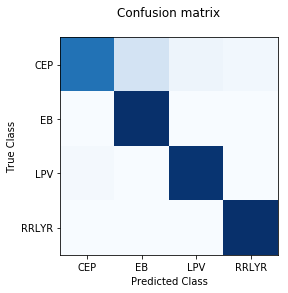

Acurracy score 0.91167192429


Metrics / Classes,CEP,EB,LPV,RRLYR
Precision score,0.987,0.789,0.912,0.967
Recall score,0.743,1.0,0.981,1.0
F score,0.848,0.882,0.945,0.983


In [39]:
draw_metrics(zt_test, MAP_BBVI_LABELS, [classes_dict[i] for i in range(K)])